In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist, regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.collocations import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from gensim.models import word2vec
from spellchecker import SpellChecker
from collections import Counter
import xgboost as xgb
import itertools
import string
import re
%matplotlib inline

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/morgandj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/morgandj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration #

In [4]:
file='movie.csv'
df=pd.read_csv(file)

In [5]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
df['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [7]:
text=df['text'].str.lower()
labels=df['label']
X_train, X_test, y_train, y_test = train_test_split(text,labels,test_size=.2,random_state=20)

In [8]:
X_train.head()

36862    ok, here it is: "nazi mountaineer befriends th...
11768    romance is in the air and love is in bloom in ...
36393    this film is described as a action/comedy. the...
12031    i love the satan pit!!! david tennant is such ...
27211    i could never stand watching happy days after ...
Name: text, dtype: object

In [9]:
stopwords_list=stopwords.words('english')
stopwords_list.append('br')
remove=['up','down','didn',"didn't",'wasn',"wasn't",'wouldn',"wouldn't"]
for word in remove:
    stopwords_list.remove(word)
    
stemmer=SnowballStemmer('english')
stopwords_stemmed=[]

for w in stopwords_list:
    stopwords_stemmed.append(stemmer.stem(w))
    
wnl=WordNetLemmatizer()
stopwords_lemmatized=[]

for w in stopwords_list:
    stopwords_lemmatized.append(wnl.lemmatize(w))

In [10]:
spell=SpellChecker()
def correct_spelling(tokens):

    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [11]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)


In [65]:

sp_tokens=tokenized_train.apply(correct_spelling)
sp_tokens.to_csv('spell_checked_Xtrain.csv')

In [67]:
sp_tokens.head(10)

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, as, a, action, com...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, days...
23690    [historical, movies, always, take, liberties, ...
32052    [i, don't, know, if, the, problem, i, had, wit...
14337    [well, eyebrow, i, must, say, that, it, please...
16003    [what, do, you, mean, son, of, actor, not, an,...
39921    [i, knew, about, this, as, a, similar, program...
Name: text, dtype: object

In [68]:
X_train.head()

36862    ok, here it is: "nazi mountaineer befriends th...
11768    romance is in the air and love is in bloom in ...
36393    this film is described as a action/comedy. the...
12031    i love the satan pit!!! david tennant is such ...
27211    i could never stand watching happy days after ...
Name: text, dtype: object

In [69]:
def transform_spell_checked(tokens):
    """
    take spell checked tokens and turn them back into a string
    separated by spaces so that they can be used in the preprocessor
    """
    string=""
    for tok in tokens:
        string=string+' '+tok
    return string


In [71]:
X_train_sc=sp_tokens.apply(transform_spell_checked)

### Tokenize ###

In [13]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)

In [14]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [15]:
ns_tk_train=tokenized_train.apply(remove_stopwords)

In [16]:
tokenized_train.head()

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, as, a, action, com...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, days...
Name: text, dtype: object

In [17]:
ns_tk_train.head()

36862    [ok, nazi, mountaineer, befriends, dalai, lama...
11768    [romance, air, love, bloom, victorian, era, en...
36393    [film, described, action, comedy, first, minut...
12031    [love, satan, pit, david, tennant, great, acto...
27211    [could, never, stand, watching, happy, days, c...
Name: text, dtype: object

In [18]:
new_df=pd.concat([tokenized_train,ns_tk_train,y_train],axis=1)
new_df.columns=['token','no-stop','label']

In [19]:
pos_reviews=new_df[new_df['label']==1]
neg_reviews=new_df[new_df['label']==0]

In [20]:
#Get Freq distributions for tokens w/ and w/o stopwords and compare top words
pos_freq = FreqDist(pos_reviews['token'].explode()).most_common(10)
pos_ns_freq = FreqDist(pos_reviews['no-stop'].explode()).most_common(10)
neg_freq = FreqDist(neg_reviews['token'].explode()).most_common(10)
neg_ns_freq = FreqDist(neg_reviews['no-stop'].explode()).most_common(10)
freqs=[pos_freq,pos_ns_freq,neg_freq,neg_ns_freq]

In [21]:
#total number of words in all reviews after stop words removed
fd=FreqDist(new_df['no-stop'].explode())
len(fd)

90425

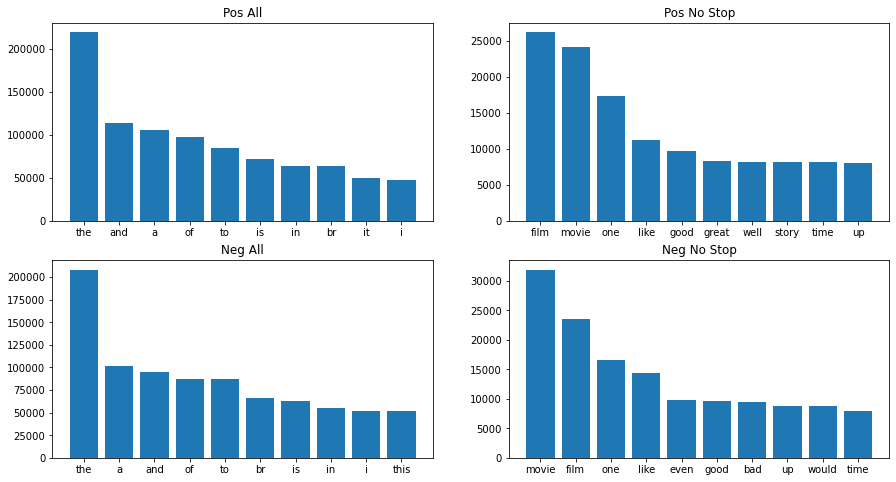

In [22]:
#Plot distributions for comparison
fig,axes=plt.subplots(2,2,figsize=(15,8))
titles=['Pos All','Pos No Stop','Neg All','Neg No Stop']

for count,ax in enumerate(axes.flatten()):
    x=[tup[0] for tup in freqs[count]]
    y=[tup[1] for tup in freqs[count]]
    ax.bar(x,y)
    ax.set_title(titles[count])


Need to investigate the token 'br'. Probably denotes a line break and shouldn't be included.

It appears that removing stop words helps differentiate between pos and neg reviews.  However, many of the top ten words are the same so we will need to train the model on a larger selection.  After removing stop words there are over 90k words in all the ratings so we will have to find a balance between reducing dimensionality and including enough training info.

In [23]:
new_df['contains_br']=new_df['no-stop'].apply(lambda x: 1 if 'br' in x else 0)
contains_br=new_df[new_df['contains_br']==1]
contains_br.head()

,token,no-stop,label,contains_br


Its clear that br is indicating line breaks. We'll remove this from all the token lists.

In [24]:
tokens_train=ns_tk_train.apply(lambda tok_list: [tok for tok in tok_list if tok!='br'])

Text(0.5, 1.0, 'negative')

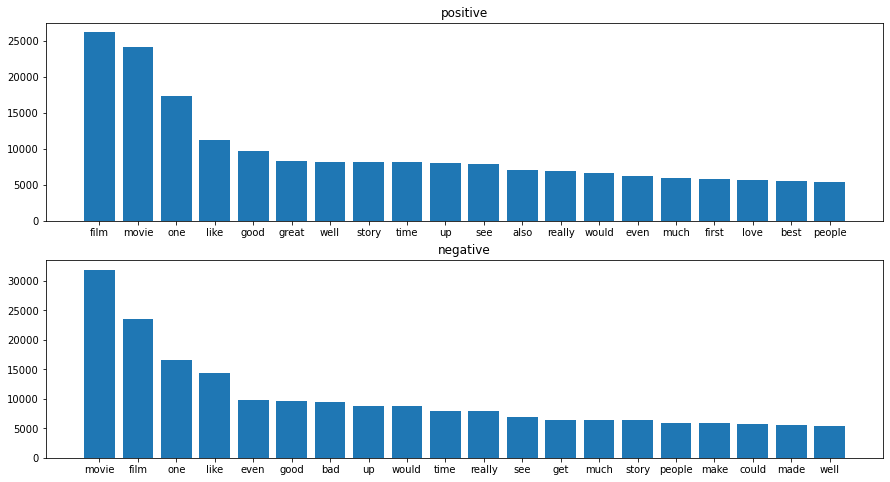

In [25]:
#redo top freq charts
tok_df=pd.concat([tokens_train,y_train],axis=1)
tok_df.columns=['token','label']
pos=tok_df[tok_df['label']==1]
neg=tok_df[tok_df['label']==0]
pos_fd=FreqDist(pos['token'].explode()).most_common(20)
neg_fd=FreqDist(neg['token'].explode()).most_common(20)

fig,axes=plt.subplots(2,figsize=(15,8))

pos_x=[tup[0] for tup in pos_fd]
pos_y=[tup[1] for tup in pos_fd]
neg_x=[tup[0] for tup in neg_fd]
neg_y=[tup[1] for tup in neg_fd]

axes[0].bar(pos_x,pos_y)
axes[0].set_title('positive')
axes[1].bar(neg_x,neg_y)
axes[1].set_title('negative')

There is not a huge difference between the top 20 words in the corpus. We'll use more for the model, but this could also indicate the importance of using bigrams to indicate how words are used together or using sequences.

# Preprocess

In [26]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [27]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    """
    Dummy class that allows us to modify only the methods that interest us,
    avoiding redudancy.
    """
    def __init__(self):
        return None

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None):
        return self

In [36]:
class Preprocess(DummyTransformer):
    
    def __init__(self,
                 stopwords_list=stopwords_list,
                 stopwords_stemmed=stopwords_stemmed,
                 stopwords_lemmatized=stopwords_lemmatized,
                 vector='count', 
                 stemming=None,
                 spell_check=False,
                n_grams=(1,1),
                max_df=1.0,
                 max_feat=None,
                chi_percent=None,
                y=None):
        #defines how the text will be preprocessed
        
        self.stopwords_list=stopwords_list
        self.stopwords_stemmed=stopwords_stemmed
        self.stopwords_lemmatized=stopwords_lemmatized
        self.vector = vector 
        #can be 'count','tfidf',or 'embedding'
        self.stemming=stemming
        #can be 'None','stem','lemmatize'
        self.spell_check=spell_check
        #True or False
        self.n_grams=n_grams
        #n_gram to pass to tokenizer like (1,1) or (1,2)
        self.max_df=max_df
        #positive float less than or equal to 1.0, to pass to vectorizer
        self.max_features=max_feat
        self.chi_percent=chi_percent
        self.y=y
        #positive integer less than 100, percent features to keep if filtering with chi2
        #None if no filtering
        #self.glove_file_=glove_file
        #None if using count or tfidf, glove file for word embeddings
         
            
    def tokenize(self,text):
        pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
        tokenizer=RegexpTokenizer(pattern)
        tokens=tokenizer.tokenize(text)
        
        if self.spell_check==True:
            tokens=correct_spelling(tokens)
        
        if self.stemming=='lemmatize':
            
            wnl=WordNetLemmatizer()
            
            stems = []
            
            for item in tokens:
                stems.append(wnl.lemmatize(item))
                
        elif self.stemming=='stem':
            stems=[]
            stemmer=SnowballStemmer('english')
            
            for item in tokens:
                stems.append(stemmer.stem(item))
        
        else:
            stems=tokens
        return stems
    
    def filter_words_by_count(self,X,tokenized):
        
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2
            
        vectorizer=CountVectorizer(stop_words=sw[idx],
                                   max_df=self.max_df,
                                   min_df=5)
        vectorizer.fit(X)

        #filter out words
        words_to_keep=vectorizer.vocabulary_.keys()
        filtered_data=tokenized.apply(lambda tok: [w for w in tok if w in words_to_keep])

        return filtered_data
    
    def build_glove(self,tokens):
        total_vocab=set([word for review in tokens for word in review])
        glove = {}
        #count=0
        #words=[]
        with open('glove.6B.300d.txt', 'rb') as f:
            for line in f:
                parts = line.split()
                word = parts[0].decode('utf-8')
                if word in total_vocab:
                    vector = np.array(parts[1:], dtype=np.float32)
                    glove[word] = vector
                    #count+=1
                    #words.append(word)
        return glove

    def transform(self, X):
        
        #tokenize according to inputs
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2
        
        if self.vector=='count':
            
            vectorizer=CountVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
        
        elif self.vector=='tfidf':
            
            vectorizer=TfidfVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
            
        elif self.vector=='embedding':
            tokenized=X.apply(self.tokenize)
            filtered=self.filter_words_by_count(X,tokenized)
            glove=self.build_glove(filtered)
            w2v=W2vVectorizer(glove)
            tokens=w2v.transform(filtered)
            
        if (self.chi_percent != None) and (self.vector != 'embedding'):
            
            selector=SelectPercentile(chi2,percentile=self.chi_percent)
            selected=selector.fit_transform(tokens,self.y)
            tokens=selected
        #print('finished')
        return tokens


In [37]:
def preprocess_grid(X_train,y_train,vector_type,params_lists):
    combos=list(itertools.product(*params_lists))
    print(len(combos))
    tokenized=[]
    count=0
    for c in combos:
        pp=Preprocess(stopwords_list=stopwords_list,
                      vector=vector_type, 
                     stemming=c[0],
                     spell_check=c[1],
                    n_grams=c[2],
                    max_df=c[3],
                    chi_percent=c[4],
                      max_feat=20000,
                    y=y_train)
        tokens=pp.transform(X_train)
        tokenized.append((c,tokens))
        count+=1
        print(count)
    return tokenized

In [38]:
def pipeline_nlp(estimator,vector_type,X_train,y_train,params_lists):
    #returns results from cross validation
    
    tokenized = preprocess_grid(X_train,y_train,vector_type,params_lists)
    results=[]

    count=0

    for features, xtrain in tokenized:
        result=cross_val_score(estimator,xtrain,y_train,cv=3)
        results.append((features,result.mean()))
        count+=1
        print(count)
    
    return pd.DataFrame(results)

# Naive Bayes #

## Count Vectorization ##

In [29]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem'],
      [False],
      [(1,1),(1,2)],
      [.2,.5,.7],
      [10]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'count',X_train,y_train,params_lists)
count_results=result_df
count_results

12
1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12


,0,1
0,"(None, False, (1, 1), 0.2, 10)",0.685250
1,"(None, False, (1, 1), 0.5, 10)",0.687156
2,"(None, False, (1, 1), 0.7, 10)",0.691844
3,"(None, False, (1, 2), 0.2, 10)",0.839062
4,"(None, False, (1, 2), 0.5, 10)",0.838781
5,"(None, False, (1, 2), 0.7, 10)",0.840000
6,"(stem, False, (1, 1), 0.2, 10)",0.645188
7,"(stem, False, (1, 1), 0.5, 10)",0.645812
8,"(stem, False, (1, 1), 0.7, 10)",0.650906
9,"(stem, False, (1, 2), 0.2, 10)",0.836750


In [55]:
count_results=pd.concat([count_results,result_df]).sort_values(by=1,ascending=False)

In [30]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['stem'],
      [False],
      [(1,2)],
      [.6,.7],
      [7,10,15]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'count',X_train,y_train,params_lists)
count_results=pd.concat([count_results,result_df]).sort_values(by=1,ascending=False)
count_results

6
1
2
3
4
5
6
1
2
3
4
5
6


,0,1
1,"(stem, False, (1, 2), 0.6, 10)",0.843437
4,"(stem, False, (1, 2), 0.7, 10)",0.843250
11,"(stem, False, (1, 2), 0.7, 10)",0.843250
10,"(stem, False, (1, 2), 0.5, 10)",0.841875
5,"(None, False, (1, 2), 0.7, 10)",0.840000
3,"(None, False, (1, 2), 0.2, 10)",0.839062
4,"(None, False, (1, 2), 0.5, 10)",0.838781
9,"(stem, False, (1, 2), 0.2, 10)",0.836750
3,"(stem, False, (1, 2), 0.7, 7)",0.828969
0,"(stem, False, (1, 2), 0.6, 7)",0.828937


In [31]:
count_results.to_csv('nb_count_results.csv')

## TFIDF Vectorization

In [31]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.4,.5,.7],
      [10,20,30]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'tfidf',X_train,y_train,params_lists)
count_results=result_df
count_results

9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9


,0,1
0,"(None, False, (1, 2), 0.4, 10)",0.835781
1,"(None, False, (1, 2), 0.4, 20)",0.860312
2,"(None, False, (1, 2), 0.4, 30)",0.857812
3,"(None, False, (1, 2), 0.5, 10)",0.836219
4,"(None, False, (1, 2), 0.5, 20)",0.860656
5,"(None, False, (1, 2), 0.5, 30)",0.858250
6,"(None, False, (1, 2), 0.7, 10)",0.837500
7,"(None, False, (1, 2), 0.7, 20)",0.860156
8,"(None, False, (1, 2), 0.7, 30)",0.858000


In [32]:
idf_results=count_results

In [33]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.2,.7],
      [10,50]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'tfidf',X_train,y_train,params_lists)
idf_results=pd.concat([idf_results,result_df]).sort_values(by=1,ascending=False)
idf_results

4
1
2
3
4
1
2
3
4


,0,1
4,"(None, False, (1, 2), 0.5, 20)",0.860656
1,"(None, False, (1, 2), 0.4, 20)",0.860312
7,"(None, False, (1, 2), 0.7, 20)",0.860156
5,"(None, False, (1, 2), 0.5, 30)",0.858250
8,"(None, False, (1, 2), 0.7, 30)",0.858000
2,"(None, False, (1, 2), 0.4, 30)",0.857812
3,"(None, False, (1, 2), 0.7, 50)",0.849125
1,"(None, False, (1, 2), 0.2, 50)",0.848969
6,"(None, False, (1, 2), 0.7, 10)",0.837500
2,"(None, False, (1, 2), 0.7, 10)",0.837500


In [34]:
idf_results.to_csv('nb_tfidf_results.csv')

### Spell Checked w/ TFIDF

In [72]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'tfidf',X_train_sc,y_train,params_lists)
result_df

1
1
1


,0,1
0,"(None, False, (1, 2), 0.6, 60)",0.844031


In [73]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.5],
      [20]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'tfidf',X_train_sc,y_train,params_lists)
result_df

1
1
1


,0,1
0,"(None, False, (1, 2), 0.5, 20)",0.858969


## Mean Word Embeddings

In [40]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem','lemmatize'],
      [False],
      [(1,1)],
      [.2,.5,.7],
      [None]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'embedding',X_train,y_train,params_lists)
nb_mwe_results=result_df.sort_values(by=1,ascending=False)
nb_mwe_results

9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9


,0,1
1,"(None, False, (1, 1), 0.5, None)",0.738969
2,"(None, False, (1, 1), 0.7, None)",0.738562
7,"(lemmatize, False, (1, 1), 0.5, None)",0.738031
8,"(lemmatize, False, (1, 1), 0.7, None)",0.736875
0,"(None, False, (1, 1), 0.2, None)",0.730437
6,"(lemmatize, False, (1, 1), 0.2, None)",0.729125
4,"(stem, False, (1, 1), 0.5, None)",0.710031
5,"(stem, False, (1, 1), 0.7, None)",0.707156
3,"(stem, False, (1, 1), 0.2, None)",0.691469


In [41]:
nb_mwe_results.to_csv('nb_mwe_results.csv')

# XGBoost

In [46]:
xgb_clf=xgb.XGBClassifier(objective='binary:logistic',
                         n_estimators=1000,
                         learning_rate=.01)

order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.5],
      [20]]

tokenized = preprocess_grid(X_train,y_train,'count',params_lists)

tokenized

#result_df=pipeline_nlp(xgb_clf,'count',X_train,y_train,params_lists)
#xgb_results=result_df.sort_values(by=1,ascending=False)
#xgb_results

1
1


[((None, False, (1, 2), 0.5, 20),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]))]

In [53]:
X_train_pp=tokenized[0][1]
features=tokenized[0][0]

xg_trainX, xg_testX, xg_trainy, xg_testy = train_test_split(X_train_pp, y_train, 
                                                           random_state=42,
                                                           stratify=y_train)
train_set=[(xg_trainX, xg_trainy)]
eval_set=[(xg_testX, xg_testy)]

In [61]:
xgb_clf=xgb.XGBClassifier(objective='binary:logistic',
                         n_estimators=2000,
                         learning_rate=.1)


xgb_clf.fit(xg_trainX,xg_trainy,
            early_stopping_rounds=50,
            eval_metric='logloss',
            eval_set=eval_set,
            verbose=True)


[0]	validation_0-logloss:0.67143
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.65396
[2]	validation_0-logloss:0.63959
[3]	validation_0-logloss:0.62698
[4]	validation_0-logloss:0.61644
[5]	validation_0-logloss:0.60689
[6]	validation_0-logloss:0.59833
[7]	validation_0-logloss:0.59081
[8]	validation_0-logloss:0.58411
[9]	validation_0-logloss:0.57722
[10]	validation_0-logloss:0.57068
[11]	validation_0-logloss:0.56484
[12]	validation_0-logloss:0.55947
[13]	validation_0-logloss:0.55473
[14]	validation_0-logloss:0.55001
[15]	validation_0-logloss:0.54542
[16]	validation_0-logloss:0.54129
[17]	validation_0-logloss:0.53718
[18]	validation_0-logloss:0.53299
[19]	validation_0-logloss:0.52959
[20]	validation_0-logloss:0.52554
[21]	validation_0-logloss:0.52214
[22]	validation_0-logloss:0.51868
[23]	validation_0-logloss:0.51565
[24]	validation_0-logloss:0.51265
[25]	validation_0-logloss:0.50984
[26]	validation_0-logloss:0.50685
[27]	validation_0-loglos

[236]	validation_0-logloss:0.34697
[237]	validation_0-logloss:0.34671
[238]	validation_0-logloss:0.34664
[239]	validation_0-logloss:0.34632
[240]	validation_0-logloss:0.34607
[241]	validation_0-logloss:0.34574
[242]	validation_0-logloss:0.34551
[243]	validation_0-logloss:0.34529
[244]	validation_0-logloss:0.34514
[245]	validation_0-logloss:0.34495
[246]	validation_0-logloss:0.34465
[247]	validation_0-logloss:0.34449
[248]	validation_0-logloss:0.34421
[249]	validation_0-logloss:0.34405
[250]	validation_0-logloss:0.34391
[251]	validation_0-logloss:0.34373
[252]	validation_0-logloss:0.34350
[253]	validation_0-logloss:0.34323
[254]	validation_0-logloss:0.34286
[255]	validation_0-logloss:0.34266
[256]	validation_0-logloss:0.34246
[257]	validation_0-logloss:0.34223
[258]	validation_0-logloss:0.34217
[259]	validation_0-logloss:0.34194
[260]	validation_0-logloss:0.34173
[261]	validation_0-logloss:0.34155
[262]	validation_0-logloss:0.34133
[263]	validation_0-logloss:0.34114
[264]	validation_0-l

[471]	validation_0-logloss:0.31324
[472]	validation_0-logloss:0.31319
[473]	validation_0-logloss:0.31310
[474]	validation_0-logloss:0.31300
[475]	validation_0-logloss:0.31286
[476]	validation_0-logloss:0.31272
[477]	validation_0-logloss:0.31263
[478]	validation_0-logloss:0.31262
[479]	validation_0-logloss:0.31254
[480]	validation_0-logloss:0.31251
[481]	validation_0-logloss:0.31247
[482]	validation_0-logloss:0.31240
[483]	validation_0-logloss:0.31227
[484]	validation_0-logloss:0.31217
[485]	validation_0-logloss:0.31202
[486]	validation_0-logloss:0.31200
[487]	validation_0-logloss:0.31195
[488]	validation_0-logloss:0.31192
[489]	validation_0-logloss:0.31185
[490]	validation_0-logloss:0.31183
[491]	validation_0-logloss:0.31167
[492]	validation_0-logloss:0.31161
[493]	validation_0-logloss:0.31155
[494]	validation_0-logloss:0.31141
[495]	validation_0-logloss:0.31139
[496]	validation_0-logloss:0.31134
[497]	validation_0-logloss:0.31118
[498]	validation_0-logloss:0.31109
[499]	validation_0-l

[706]	validation_0-logloss:0.29858
[707]	validation_0-logloss:0.29845
[708]	validation_0-logloss:0.29842
[709]	validation_0-logloss:0.29835
[710]	validation_0-logloss:0.29839
[711]	validation_0-logloss:0.29822
[712]	validation_0-logloss:0.29817
[713]	validation_0-logloss:0.29809
[714]	validation_0-logloss:0.29800
[715]	validation_0-logloss:0.29798
[716]	validation_0-logloss:0.29791
[717]	validation_0-logloss:0.29790
[718]	validation_0-logloss:0.29786
[719]	validation_0-logloss:0.29784
[720]	validation_0-logloss:0.29786
[721]	validation_0-logloss:0.29781
[722]	validation_0-logloss:0.29783
[723]	validation_0-logloss:0.29775
[724]	validation_0-logloss:0.29771
[725]	validation_0-logloss:0.29768
[726]	validation_0-logloss:0.29759
[727]	validation_0-logloss:0.29759
[728]	validation_0-logloss:0.29756
[729]	validation_0-logloss:0.29755
[730]	validation_0-logloss:0.29755
[731]	validation_0-logloss:0.29751
[732]	validation_0-logloss:0.29745
[733]	validation_0-logloss:0.29746
[734]	validation_0-l

[941]	validation_0-logloss:0.29048
[942]	validation_0-logloss:0.29047
[943]	validation_0-logloss:0.29040
[944]	validation_0-logloss:0.29037
[945]	validation_0-logloss:0.29028
[946]	validation_0-logloss:0.29028
[947]	validation_0-logloss:0.29025
[948]	validation_0-logloss:0.29020
[949]	validation_0-logloss:0.29025
[950]	validation_0-logloss:0.29027
[951]	validation_0-logloss:0.29024
[952]	validation_0-logloss:0.29025
[953]	validation_0-logloss:0.29024
[954]	validation_0-logloss:0.29021
[955]	validation_0-logloss:0.29012
[956]	validation_0-logloss:0.29007
[957]	validation_0-logloss:0.29003
[958]	validation_0-logloss:0.29001
[959]	validation_0-logloss:0.29005
[960]	validation_0-logloss:0.28997
[961]	validation_0-logloss:0.28992
[962]	validation_0-logloss:0.28991
[963]	validation_0-logloss:0.28984
[964]	validation_0-logloss:0.28979
[965]	validation_0-logloss:0.28977
[966]	validation_0-logloss:0.28973
[967]	validation_0-logloss:0.28972
[968]	validation_0-logloss:0.28971
[969]	validation_0-l

[1171]	validation_0-logloss:0.28510
[1172]	validation_0-logloss:0.28507
[1173]	validation_0-logloss:0.28505
[1174]	validation_0-logloss:0.28505
[1175]	validation_0-logloss:0.28498
[1176]	validation_0-logloss:0.28491
[1177]	validation_0-logloss:0.28488
[1178]	validation_0-logloss:0.28485
[1179]	validation_0-logloss:0.28485
[1180]	validation_0-logloss:0.28484
[1181]	validation_0-logloss:0.28479
[1182]	validation_0-logloss:0.28479
[1183]	validation_0-logloss:0.28480
[1184]	validation_0-logloss:0.28476
[1185]	validation_0-logloss:0.28476
[1186]	validation_0-logloss:0.28476
[1187]	validation_0-logloss:0.28472
[1188]	validation_0-logloss:0.28473
[1189]	validation_0-logloss:0.28474
[1190]	validation_0-logloss:0.28471
[1191]	validation_0-logloss:0.28471
[1192]	validation_0-logloss:0.28471
[1193]	validation_0-logloss:0.28471
[1194]	validation_0-logloss:0.28471
[1195]	validation_0-logloss:0.28472
[1196]	validation_0-logloss:0.28467
[1197]	validation_0-logloss:0.28467
[1198]	validation_0-logloss:

[1399]	validation_0-logloss:0.28301
[1400]	validation_0-logloss:0.28297
[1401]	validation_0-logloss:0.28296
[1402]	validation_0-logloss:0.28295
[1403]	validation_0-logloss:0.28294
[1404]	validation_0-logloss:0.28288
[1405]	validation_0-logloss:0.28289
[1406]	validation_0-logloss:0.28290
[1407]	validation_0-logloss:0.28294
[1408]	validation_0-logloss:0.28294
[1409]	validation_0-logloss:0.28295
[1410]	validation_0-logloss:0.28292
[1411]	validation_0-logloss:0.28288
[1412]	validation_0-logloss:0.28292
[1413]	validation_0-logloss:0.28288
[1414]	validation_0-logloss:0.28284
[1415]	validation_0-logloss:0.28277
[1416]	validation_0-logloss:0.28284
[1417]	validation_0-logloss:0.28287
[1418]	validation_0-logloss:0.28282
[1419]	validation_0-logloss:0.28283
[1420]	validation_0-logloss:0.28282
[1421]	validation_0-logloss:0.28282
[1422]	validation_0-logloss:0.28281
[1423]	validation_0-logloss:0.28284
[1424]	validation_0-logloss:0.28284
[1425]	validation_0-logloss:0.28284
[1426]	validation_0-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
y_hat=xgb_clf.predict(xg_testX)
accuracy_score(xg_testy,y_hat)

0.883375

In [63]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized = preprocess_grid(X_train,y_train,'count',params_lists)

X_train_pp=tokenized[0][1]
features=tokenized[0][0]

xg_trainX, xg_testX, xg_trainy, xg_testy = train_test_split(X_train_pp, y_train, 
                                                           random_state=42,
                                                           stratify=y_train)
train_set=[(xg_trainX, xg_trainy)]
eval_set=[(xg_testX, xg_testy)]

xgb_clf=xgb.XGBClassifier(objective='binary:logistic',
                         n_estimators=2000,
                         learning_rate=.1)


xgb_clf.fit(xg_trainX,xg_trainy,
            early_stopping_rounds=50,
            eval_metric='logloss',
            eval_set=eval_set,
            verbose=True)

1
1
[0]	validation_0-logloss:0.67149
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.65405
[2]	validation_0-logloss:0.63969
[3]	validation_0-logloss:0.62735
[4]	validation_0-logloss:0.61683
[5]	validation_0-logloss:0.60744
[6]	validation_0-logloss:0.59897
[7]	validation_0-logloss:0.59137
[8]	validation_0-logloss:0.58464
[9]	validation_0-logloss:0.57796
[10]	validation_0-logloss:0.57144
[11]	validation_0-logloss:0.56557
[12]	validation_0-logloss:0.56090
[13]	validation_0-logloss:0.55596
[14]	validation_0-logloss:0.55091
[15]	validation_0-logloss:0.54621
[16]	validation_0-logloss:0.54207
[17]	validation_0-logloss:0.53786
[18]	validation_0-logloss:0.53426
[19]	validation_0-logloss:0.53010
[20]	validation_0-logloss:0.52663
[21]	validation_0-logloss:0.52320
[22]	validation_0-logloss:0.51954
[23]	validation_0-logloss:0.51617
[24]	validation_0-logloss:0.51305
[25]	validation_0-logloss:0.51009
[26]	validation_0-logloss:0.50683
[27]	validation_0-lo

[236]	validation_0-logloss:0.34677
[237]	validation_0-logloss:0.34640
[238]	validation_0-logloss:0.34616
[239]	validation_0-logloss:0.34605
[240]	validation_0-logloss:0.34585
[241]	validation_0-logloss:0.34565
[242]	validation_0-logloss:0.34545
[243]	validation_0-logloss:0.34514
[244]	validation_0-logloss:0.34485
[245]	validation_0-logloss:0.34464
[246]	validation_0-logloss:0.34426
[247]	validation_0-logloss:0.34403
[248]	validation_0-logloss:0.34372
[249]	validation_0-logloss:0.34345
[250]	validation_0-logloss:0.34332
[251]	validation_0-logloss:0.34306
[252]	validation_0-logloss:0.34282
[253]	validation_0-logloss:0.34261
[254]	validation_0-logloss:0.34239
[255]	validation_0-logloss:0.34229
[256]	validation_0-logloss:0.34205
[257]	validation_0-logloss:0.34193
[258]	validation_0-logloss:0.34172
[259]	validation_0-logloss:0.34153
[260]	validation_0-logloss:0.34115
[261]	validation_0-logloss:0.34086
[262]	validation_0-logloss:0.34068
[263]	validation_0-logloss:0.34052
[264]	validation_0-l

[471]	validation_0-logloss:0.31443
[472]	validation_0-logloss:0.31431
[473]	validation_0-logloss:0.31430
[474]	validation_0-logloss:0.31430
[475]	validation_0-logloss:0.31421
[476]	validation_0-logloss:0.31413
[477]	validation_0-logloss:0.31406
[478]	validation_0-logloss:0.31401
[479]	validation_0-logloss:0.31388
[480]	validation_0-logloss:0.31381
[481]	validation_0-logloss:0.31372
[482]	validation_0-logloss:0.31369
[483]	validation_0-logloss:0.31364
[484]	validation_0-logloss:0.31354
[485]	validation_0-logloss:0.31348
[486]	validation_0-logloss:0.31362
[487]	validation_0-logloss:0.31355
[488]	validation_0-logloss:0.31345
[489]	validation_0-logloss:0.31335
[490]	validation_0-logloss:0.31331
[491]	validation_0-logloss:0.31320
[492]	validation_0-logloss:0.31304
[493]	validation_0-logloss:0.31300
[494]	validation_0-logloss:0.31285
[495]	validation_0-logloss:0.31283
[496]	validation_0-logloss:0.31282
[497]	validation_0-logloss:0.31272
[498]	validation_0-logloss:0.31272
[499]	validation_0-l

[706]	validation_0-logloss:0.30057
[707]	validation_0-logloss:0.30058
[708]	validation_0-logloss:0.30051
[709]	validation_0-logloss:0.30051
[710]	validation_0-logloss:0.30048
[711]	validation_0-logloss:0.30046
[712]	validation_0-logloss:0.30042
[713]	validation_0-logloss:0.30042
[714]	validation_0-logloss:0.30033
[715]	validation_0-logloss:0.30026
[716]	validation_0-logloss:0.30027
[717]	validation_0-logloss:0.30022
[718]	validation_0-logloss:0.30015
[719]	validation_0-logloss:0.30009
[720]	validation_0-logloss:0.30001
[721]	validation_0-logloss:0.29996
[722]	validation_0-logloss:0.29989
[723]	validation_0-logloss:0.29984
[724]	validation_0-logloss:0.29983
[725]	validation_0-logloss:0.29974
[726]	validation_0-logloss:0.29976
[727]	validation_0-logloss:0.29975
[728]	validation_0-logloss:0.29973
[729]	validation_0-logloss:0.29975
[730]	validation_0-logloss:0.29964
[731]	validation_0-logloss:0.29959
[732]	validation_0-logloss:0.29954
[733]	validation_0-logloss:0.29946
[734]	validation_0-l

[941]	validation_0-logloss:0.29362
[942]	validation_0-logloss:0.29363
[943]	validation_0-logloss:0.29359
[944]	validation_0-logloss:0.29355
[945]	validation_0-logloss:0.29356
[946]	validation_0-logloss:0.29351
[947]	validation_0-logloss:0.29351
[948]	validation_0-logloss:0.29352
[949]	validation_0-logloss:0.29356
[950]	validation_0-logloss:0.29356
[951]	validation_0-logloss:0.29351
[952]	validation_0-logloss:0.29339
[953]	validation_0-logloss:0.29345
[954]	validation_0-logloss:0.29341
[955]	validation_0-logloss:0.29347
[956]	validation_0-logloss:0.29348
[957]	validation_0-logloss:0.29346
[958]	validation_0-logloss:0.29343
[959]	validation_0-logloss:0.29345
[960]	validation_0-logloss:0.29346
[961]	validation_0-logloss:0.29350
[962]	validation_0-logloss:0.29355
[963]	validation_0-logloss:0.29345
[964]	validation_0-logloss:0.29341
[965]	validation_0-logloss:0.29339
[966]	validation_0-logloss:0.29332
[967]	validation_0-logloss:0.29334
[968]	validation_0-logloss:0.29331
[969]	validation_0-l

[1171]	validation_0-logloss:0.29039
[1172]	validation_0-logloss:0.29037
[1173]	validation_0-logloss:0.29032
[1174]	validation_0-logloss:0.29032
[1175]	validation_0-logloss:0.29027
[1176]	validation_0-logloss:0.29024
[1177]	validation_0-logloss:0.29022
[1178]	validation_0-logloss:0.29022
[1179]	validation_0-logloss:0.29023
[1180]	validation_0-logloss:0.29022
[1181]	validation_0-logloss:0.29021
[1182]	validation_0-logloss:0.29017
[1183]	validation_0-logloss:0.29017
[1184]	validation_0-logloss:0.29012
[1185]	validation_0-logloss:0.29014
[1186]	validation_0-logloss:0.29016
[1187]	validation_0-logloss:0.29008
[1188]	validation_0-logloss:0.29007
[1189]	validation_0-logloss:0.29004
[1190]	validation_0-logloss:0.29005
[1191]	validation_0-logloss:0.29006
[1192]	validation_0-logloss:0.29003
[1193]	validation_0-logloss:0.29005
[1194]	validation_0-logloss:0.29008
[1195]	validation_0-logloss:0.29004
[1196]	validation_0-logloss:0.29002
[1197]	validation_0-logloss:0.29000
[1198]	validation_0-logloss:

[1399]	validation_0-logloss:0.28739
[1400]	validation_0-logloss:0.28737
[1401]	validation_0-logloss:0.28742
[1402]	validation_0-logloss:0.28744
[1403]	validation_0-logloss:0.28744
[1404]	validation_0-logloss:0.28742
[1405]	validation_0-logloss:0.28739
[1406]	validation_0-logloss:0.28739
[1407]	validation_0-logloss:0.28733
[1408]	validation_0-logloss:0.28736
[1409]	validation_0-logloss:0.28733
[1410]	validation_0-logloss:0.28732
[1411]	validation_0-logloss:0.28734
[1412]	validation_0-logloss:0.28743
[1413]	validation_0-logloss:0.28739
[1414]	validation_0-logloss:0.28747
[1415]	validation_0-logloss:0.28752
[1416]	validation_0-logloss:0.28753
[1417]	validation_0-logloss:0.28752
[1418]	validation_0-logloss:0.28750
[1419]	validation_0-logloss:0.28746
[1420]	validation_0-logloss:0.28747
[1421]	validation_0-logloss:0.28747
[1422]	validation_0-logloss:0.28747
[1423]	validation_0-logloss:0.28743
[1424]	validation_0-logloss:0.28742
[1425]	validation_0-logloss:0.28743
[1426]	validation_0-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
y_hat=xgb_clf.predict(xg_testX)
accuracy_score(xg_testy,y_hat)

0.884875

# Baseline Model w/ Naive Bayes

In [21]:
#Create a train and validation set
train_X, val_X, train_y, val_y = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.2,
                                                  random_state=40)

CountVectorizer will be used on original text with the desired characteristics outlined in the data exploration above in order to get the model features.

## Count Vectorization

In [23]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=10000)
tokens_train=vectorizer.fit_transform(X_train).toarray()

In [39]:
baseline=GaussianNB()
baseline.fit(tokens_train,y_train)

results=cross_val_score(baseline,tokens_train,y_train)
results

array([0.73828125, 0.75203125, 0.7396875 , 0.73375   , 0.7403125 ])

In [ ]:
#Try different max_features to see which has best results

In [40]:
max_to_try=[100,1000,5000,10000]
results={}

for m in max_to_try:
    vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=m)
    tokens_train=vectorizer.fit_transform(X_train).toarray()
    
    baseline=GaussianNB()
    baseline.fit(tokens_train,y_train)

    results[m]=cross_val_score(baseline,tokens_train,y_train)
    
results

{100: array([0.68875   , 0.70234375, 0.69625   , 0.6840625 , 0.68328125]),
 1000: array([0.8103125 , 0.8125    , 0.80671875, 0.80390625, 0.8078125 ]),
 5000: array([0.73828125, 0.75203125, 0.7396875 , 0.73375   , 0.7403125 ]),
 10000: array([0.7171875 , 0.72625   , 0.7034375 , 0.70703125, 0.7203125 ])}

## TFIDF Vectorization

In [23]:
def correct_spelling(tokens):
    spell=SpellChecker()
    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [24]:
test=['hredf','hi','doggy','mvie']
correct_spelling(test)

['red', 'hi', 'doggy', 'movie']

In [24]:
tfidf = TfidfVectorizer(max_features=1000,stop_words=stopwords_list)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train).toarray()

tfidf_model=GaussianNB()
tfidf_model.fit(X_train_vectorized,y_train)

results=cross_val_score(tfidf_model,X_train_vectorized,y_train)
results.mean()

0.81509375

In [39]:
max_to_try=[1000,15000]
results={}

for m in max_to_try:
    tfidf = TfidfVectorizer(max_features=m,stop_words=stopwords_list)
    X_train_vectorized = tfidf.fit_transform(X_train).toarray()

    tfidf_model=GaussianNB()
    tfidf_model.fit(X_train_vectorized,y_train)

    cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
    results[m]=cv.mean()
    
results

{1000: 0.81509375, 15000: 0.7502812500000001}

## Add Lemmatization

In [64]:
test=X_train[5]

In [25]:
#Custom tokenizer with Lemmatization
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

def tokenize(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer=RegexpTokenizer(pattern)
    tokens=tokenizer.tokenize(text)
    lemmas = []
    wnl=WordNetLemmatizer()
    for item in tokens:
        lemmas.append(wnl.lemmatize(item))
    return lemmas


In [71]:
#Custom tokenizer with Lemmatization
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

def tokenize(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer=RegexpTokenizer(pattern)
    tokens=tokenizer.tokenize(text)
    lemmas = []
    wnl=WordNetLemmatizer()
    for item in tokens:
        lemmas.append(wnl.lemmatize(item))
    return lemmas


In [72]:
X_train.apply(tokenize)

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, a, a, action, come...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, day,...
                               ...                        
31962    [this, film, grab, you, from, the, opening, sc...
23452    [ok, so, it's, not, a, masterpiece, like, the,...
23775    [jefferey, dahmer, wa, one, sick, guy, there's...
37135    [unfortunately, this, ha, been, showing, on, s...
27098    [johnny, dangerously, fall, completely, in, th...
Name: text, Length: 32000, dtype: object

In [84]:
tfidf = TfidfVectorizer(max_features=1000,stop_words=stopwords_list,tokenizer=tokenize)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train).toarray()

tfidf_model=GaussianNB()
tfidf_model.fit(X_train_vectorized,y_train)

results=cross_val_score(tfidf_model,X_train_vectorized,y_train)
results.mean()

0.8108124999999999

Model actually performed slightly worse with lemmatization.

## Bigrams

In [1]:
tfidf = TfidfVectorizer(max_features=1000,
                        ngram_range=(1,2),
                        min_df=5,
                        max_df=.3,
                        stop_words=stopwords_list)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train).toarray()

tfidf_model=GaussianNB()
tfidf_model.fit(X_train_vectorized,y_train)

results=cross_val_score(tfidf_model,X_train_vectorized,y_train)
results.mean()

NameError: name 'TfidfVectorizer' is not defined

In [94]:
max_to_try=[1500,5000,7500,10000]
max_df_to_try=[.3,.5,.7]
results={}

for m in max_to_try:
    tfidf = TfidfVectorizer(max_features=m,
                        ngram_range=(1,2),
                        min_df=5,
                        max_df=.5,
                        stop_words=stopwords_list)
    X_train_vectorized = tfidf.fit_transform(X_train).toarray()

    tfidf_model=GaussianNB()
    tfidf_model.fit(X_train_vectorized,y_train)

    cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
    results[m]=cv.mean()
    
results

{1500: 0.82478125, 5000: 0.82659375, 7500: 0.8243124999999999, 10000: 0.8225}

In [99]:
ngrams=[(1,2),(2,2),(1,3),(3,3)]
max_to_try=[1500,5000,7500]
max_df_to_try=[.3,.5,.7]

results={}

for m in max_to_try:
    for d in max_df_to_try:
        for n in ngrams:
            tfidf = TfidfVectorizer(max_features=m,
                                ngram_range=n,
                                min_df=5,
                                max_df=d,
                                stop_words=stopwords_list)
            X_train_vectorized = tfidf.fit_transform(X_train).toarray()

            tfidf_model=GaussianNB()
            tfidf_model.fit(X_train_vectorized,y_train)

            cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
            results[(m,d,n)]=cv.mean()
    
results

{(1500, 0.3, (1, 2)): 0.8240000000000001,
 (1500, 0.3, (2, 2)): 0.7584375,
 (1500, 0.3, (1, 3)): 0.8240000000000001,
 (1500, 0.3, (3, 3)): 0.6346875000000001,
 (1500, 0.5, (1, 2)): 0.82478125,
 (1500, 0.5, (2, 2)): 0.7584375,
 (1500, 0.5, (1, 3)): 0.8243750000000001,
 (1500, 0.5, (3, 3)): 0.6346875000000001,
 (1500, 0.7, (1, 2)): 0.8252499999999999,
 (1500, 0.7, (2, 2)): 0.7584375,
 (1500, 0.7, (1, 3)): 0.8251875,
 (1500, 0.7, (3, 3)): 0.6346875000000001,
 (5000, 0.3, (1, 2)): 0.826,
 (5000, 0.3, (2, 2)): 0.792875,
 (5000, 0.3, (1, 3)): 0.8258749999999999,
 (5000, 0.3, (3, 3)): 0.669125,
 (5000, 0.5, (1, 2)): 0.82659375,
 (5000, 0.5, (2, 2)): 0.792875,
 (5000, 0.5, (1, 3)): 0.826125,
 (5000, 0.5, (3, 3)): 0.669125,
 (5000, 0.7, (1, 2)): 0.82596875,
 (5000, 0.7, (2, 2)): 0.792875,
 (5000, 0.7, (1, 3)): 0.8262812499999999,
 (5000, 0.7, (3, 3)): 0.669125,
 (7500, 0.3, (1, 2)): 0.82409375,
 (7500, 0.3, (2, 2)): 0.8011874999999999,
 (7500, 0.3, (1, 3)): 0.8240624999999999,
 (7500, 0.3, (3, 

In [107]:
sorted(list(zip(results.keys(),results.values())),key=lambda x:x[1],reverse=True)

[((5000, 0.5, (1, 2)), 0.82659375),
 ((5000, 0.7, (1, 3)), 0.8262812499999999),
 ((5000, 0.5, (1, 3)), 0.826125),
 ((5000, 0.3, (1, 2)), 0.826),
 ((5000, 0.7, (1, 2)), 0.82596875),
 ((5000, 0.3, (1, 3)), 0.8258749999999999),
 ((1500, 0.7, (1, 2)), 0.8252499999999999),
 ((1500, 0.7, (1, 3)), 0.8251875),
 ((1500, 0.5, (1, 2)), 0.82478125),
 ((1500, 0.5, (1, 3)), 0.8243750000000001),
 ((7500, 0.7, (1, 2)), 0.82434375),
 ((7500, 0.5, (1, 2)), 0.8243124999999999),
 ((7500, 0.3, (1, 2)), 0.82409375),
 ((7500, 0.3, (1, 3)), 0.8240624999999999),
 ((1500, 0.3, (1, 2)), 0.8240000000000001),
 ((1500, 0.3, (1, 3)), 0.8240000000000001),
 ((7500, 0.7, (1, 3)), 0.8237500000000001),
 ((7500, 0.5, (1, 3)), 0.82371875),
 ((7500, 0.3, (2, 2)), 0.8011874999999999),
 ((7500, 0.5, (2, 2)), 0.8011874999999999),
 ((7500, 0.7, (2, 2)), 0.8011874999999999),
 ((5000, 0.3, (2, 2)), 0.792875),
 ((5000, 0.5, (2, 2)), 0.792875),
 ((5000, 0.7, (2, 2)), 0.792875),
 ((1500, 0.3, (2, 2)), 0.7584375),
 ((1500, 0.5, (2, 2

In [25]:
ngrams=[(1,2),(2,2),(1,3),(3,3)]
max_df_to_try=[.3,.2]

results={}


for d in max_df_to_try:
    for n in ngrams:
        tfidf = TfidfVectorizer(ngram_range=n,
                            max_features=10000,
                            min_df=5,
                            max_df=d,
                            stop_words=stopwords_list)
        X_train_vectorized = tfidf.fit_transform(X_train).toarray()

        tfidf_model=GaussianNB()
        tfidf_model.fit(X_train_vectorized,y_train)

        cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
        results[(d,n)]=cv.mean()
    
sorted(list(zip(results.keys(),results.values())),key=lambda x:x[1],reverse=True)

[((0.2, (1, 2)), 0.82378125),
 ((0.3, (1, 2)), 0.8232812500000002),
 ((0.2, (1, 3)), 0.8229375000000001),
 ((0.3, (1, 3)), 0.82290625),
 ((0.3, (2, 2)), 0.8063437500000001),
 ((0.2, (2, 2)), 0.8063437500000001),
 ((0.3, (3, 3)), 0.67884375),
 ((0.2, (3, 3)), 0.67884375)]

## Feature Selection w/ MI and Chi2

In [32]:
vectorizer=CountVectorizer(binary=True,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()



In [36]:
percents=[.2,.3,.4,.5]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.2: 0.8035937499999999,
 0.3: 0.8080937499999999,
 0.4: 0.8088437500000001,
 0.5: 0.81459375}

In [38]:
percents=[.7,.8]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.7: 0.8203125, 0.8: 0.8205312500000002}

In [40]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()
percents=[5,10,25]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.5: 0.82825, 0.7: 0.8323750000000001, 0.8: 0.8195}

In [ ]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()
percents=[50,70]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

In [97]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()
print(tokens_train.shape)
selector=SelectPercentile(chi2,percentile=50)
train_selected=selector.fit_transform(tokens_train,y_train)
print(train_selected.shape)

(32000, 84469)
(32000, 423)


In [98]:
selector=SelectPercentile(chi2,percentile=50)
train_selected=selector.fit_transform(tokens_train,y_train)
print(train_selected.shape)

(32000, 42234)


In [10]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list,
                          ngram_range=(1,2),min_df=5,max_df=.6)
tokens_train=vectorizer.fit_transform(X_train).toarray()
percents=[.7,.8]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.7: 0.81840625, 0.8: 0.8239375000000001}

## Mean Word Embeddings 

In [26]:
total_vocab=set([word for review in tokenized_train for word in review])

In [34]:
glove = {}
count=0
words=[]
with open('glove.6B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
            count+=1
            words.append(word)
print(count)
print(count/len(total_vocab)*100)

65074
71.83194984104556


In [38]:
missing_words=[w for w in total_vocab if w not in words]
len(missing_words)

25518

In [21]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [80]:
wv=W2vVectorizer(glove)


In [81]:
nb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Naive Bayes', GaussianNB())])

In [33]:
results=cross_val_score(nb,tokenized_train,y_train)
print(results)
results.mean()

[0.7075     0.70328125 0.70140625 0.706875   0.698125  ]


0.7034375

In [58]:
test=pd.Series(Counter(ns_tk_train[0]))

In [60]:
test[test>1].index

Index(['thunderbirds', 'school', 'wanted', 'one', 'sapiens'], dtype='object')

In [14]:
def build_glove(file,tokens):
    total_vocab=set([word for review in tokens for word in review])
    glove = {}
    count=0
    words=[]
    with open(file, 'rb') as f:
        for line in f:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in total_vocab:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
                count+=1
                words.append(word)
    return glove, count, words

In [113]:
#rank words by count and remove max/min

def filter_words_by_count(data,max_df,min_count):
    
    vectorizer=CountVectorizer(stop_words=stopwords_list,max_df=max_df,min_df=min_count)
    vectorizer.fit(X_train)
    
    #filter out words
    words_to_keep=vectorizer.vocabulary_.keys()
    print(len(words_to_keep))
    filtered_data=data.apply(lambda tok: [w for w in tok if w in words_to_keep])
    
    return filtered_data
    

In [83]:
ns_tk_train.shape

(32000,)

In [114]:
filtered_train=filter_words_by_count(ns_tk_train,max_df=.3,min_count=5)

30265


In [95]:
filtered_train.shape

(32000,)

In [117]:
glove,c,w=build_glove('glove.42B.300d.txt',ns_tk_train)
print(c)

nb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Naive Bayes', GaussianNB())])

results=cross_val_score(nb,ns_tk_train,y_train)
print(results)
results.mean()

74295
[0.76859375 0.75515625 0.7590625  0.761875   0.7546875 ]


0.7598749999999999

In [118]:
glove,c,w=build_glove('glove.42B.300d.txt',filtered_train)
print(c)

nb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Naive Bayes', GaussianNB())])

results=cross_val_score(nb,filtered_train,y_train)
print(results)
results.mean()

29811
[0.77921875 0.76109375 0.77140625 0.77078125 0.76359375]


0.76921875

## Best Naive Bayes Model

In [9]:
#best model below- plot confusion matrix
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()

selector=SelectPercentile(chi2,percentile=.7)
train_selected=selector.fit_transform(tokens_train,y_train)
    
nb_model=GaussianNB()
nb_model.fit(train_selected,y_train)

result=cross_val_score(nb_model,train_selected,y_train)
result.mean()

0.8323750000000001

In [12]:
tokens_test=vectorizer.transform(X_test).toarray()
test_selected=selector.transform(tokens_test)

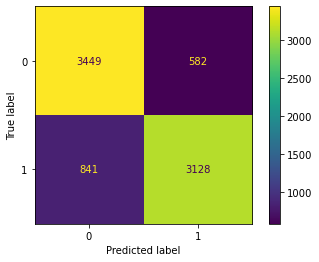

In [13]:
plot_confusion_matrix(nb_model,test_selected,y_test)

# Logistic Regression

Try Logreg with count/tfidf vectors, stemming, n-grams

In [11]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=5000)
tokens_train=vectorizer.fit_transform(X_train).toarray()

logreg=LogisticRegression(max_iter=500)

logreg.fit(tokens_train,y_train)
results=cross_val_score(logreg,tokens_train,y_train)
print(results)
results.mean()

[0.85421875 0.85734375 0.85875    0.8571875  0.86359375]


0.85821875

In [77]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [80]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [82]:
X_train.head()

36862    ok, here it is: "nazi mountaineer befriends th...
11768    romance is in the air and love is in bloom in ...
36393    this film is described as a action/comedy. the...
12031    i love the satan pit!!! david tennant is such ...
27211    i could never stand watching happy days after ...
Name: text, dtype: object